In [1]:
#!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn
#!pip install imblearn

In [2]:
import os
import sys
import subprocess

# List of required libraries
required_libraries = [
    "pandas", "numpy", "scikit-learn", "tensorflow", "matplotlib", "seaborn"
]

# Function to install missing libraries
def install_missing_libraries():
    for library in required_libraries:
        try:
            _import_(library)
        except ImportError:
            print(f"Installing missing library: {library}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])

In [3]:
from IPython.core.display import display, HTML

# Set output area to use the full width of the browser window
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\archi\AppData\Local\Temp\ipykernel_15812\2698579236.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, brier_score_loss, auc
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif

In [5]:
df = pd.read_csv('mushroom_cleaned.csv')

In [6]:
if 'name' in df.columns:
    df = df.drop(columns=['name'])

In [7]:
df = df.fillna(df.median())

In [8]:
df = pd.get_dummies(df)

In [9]:
df

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1
54031,82,2,3,2,1.186164,490,12,0.943195,1
54032,82,5,3,2,0.915593,584,12,0.888450,1
54033,79,2,3,2,1.034963,491,12,0.888450,1


In [10]:
df.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


In [11]:
df.dtypes

cap-diameter         int64
cap-shape            int64
gill-attachment      int64
gill-color           int64
stem-height        float64
stem-width           int64
stem-color           int64
season             float64
class                int64
dtype: object

In [12]:
X = df.drop(columns=['class'])
y = df['class']

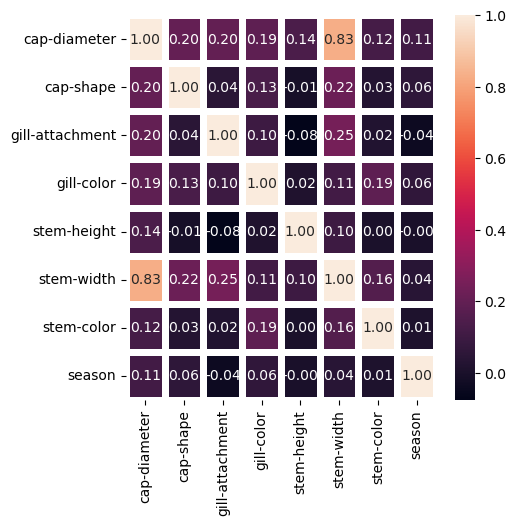

In [13]:
# Determining Correlation between different attributes
fig, axis = plt.subplots(figsize=(5, 5))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=5, fmt='.2f', ax=axis)
plt.show()

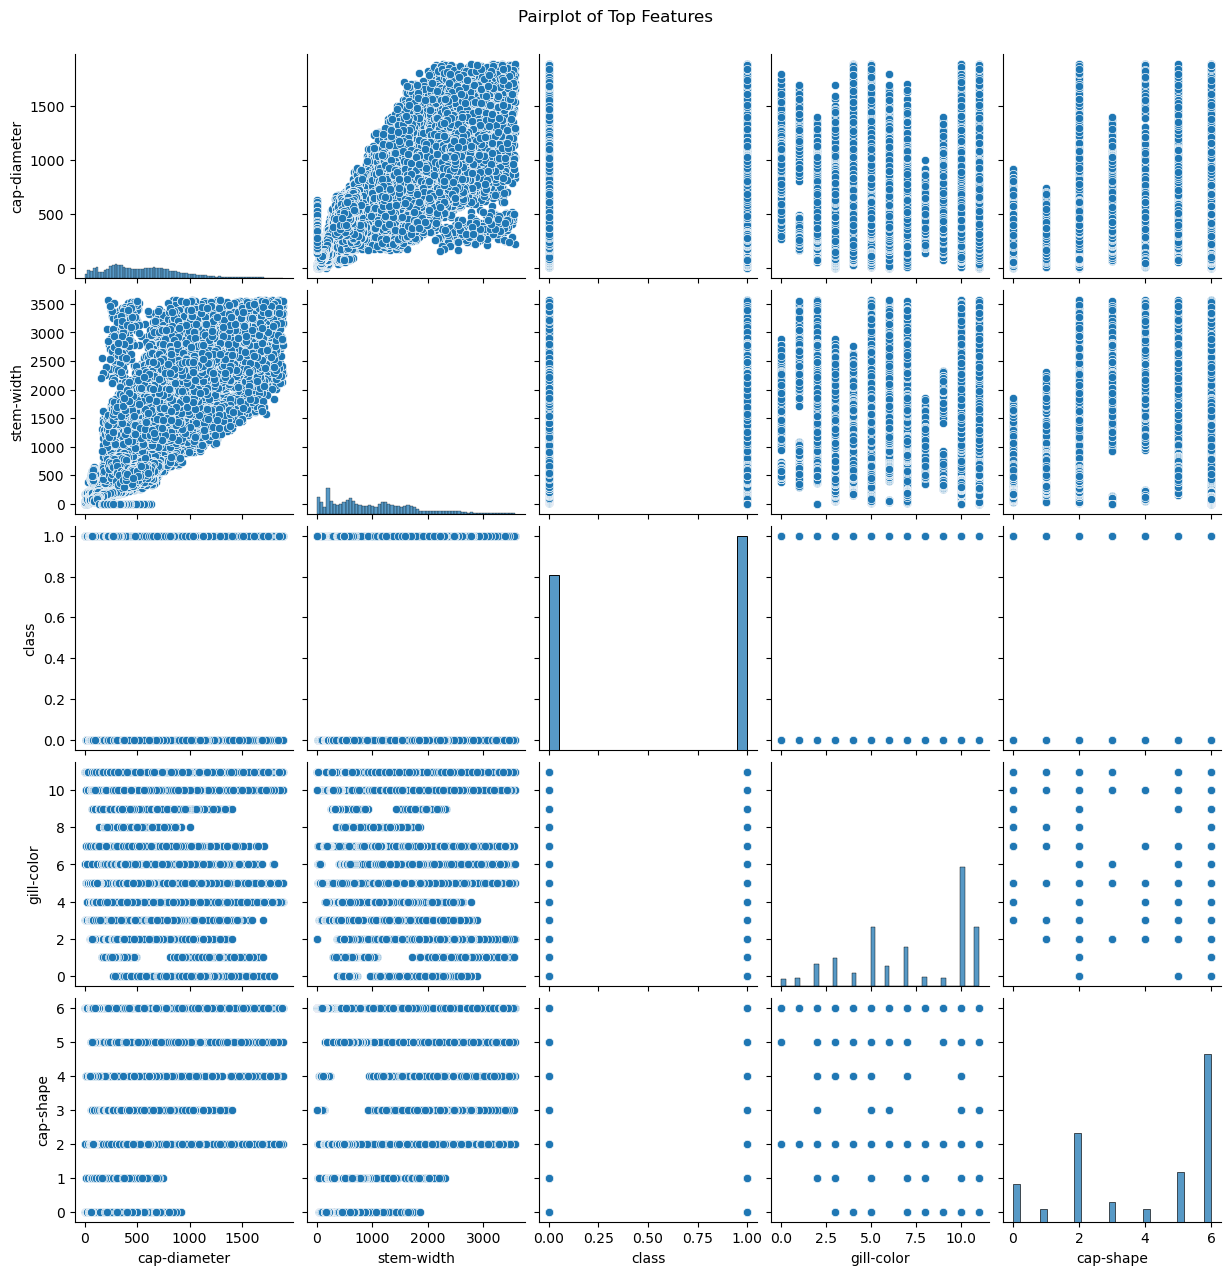

In [14]:
top_features = df.corr().abs().sum().sort_values(ascending=False).index[:5]
sns.pairplot(df[top_features], height=2.5)
plt.suptitle("Pairplot of Top Features", y=1.02)
plt.show()

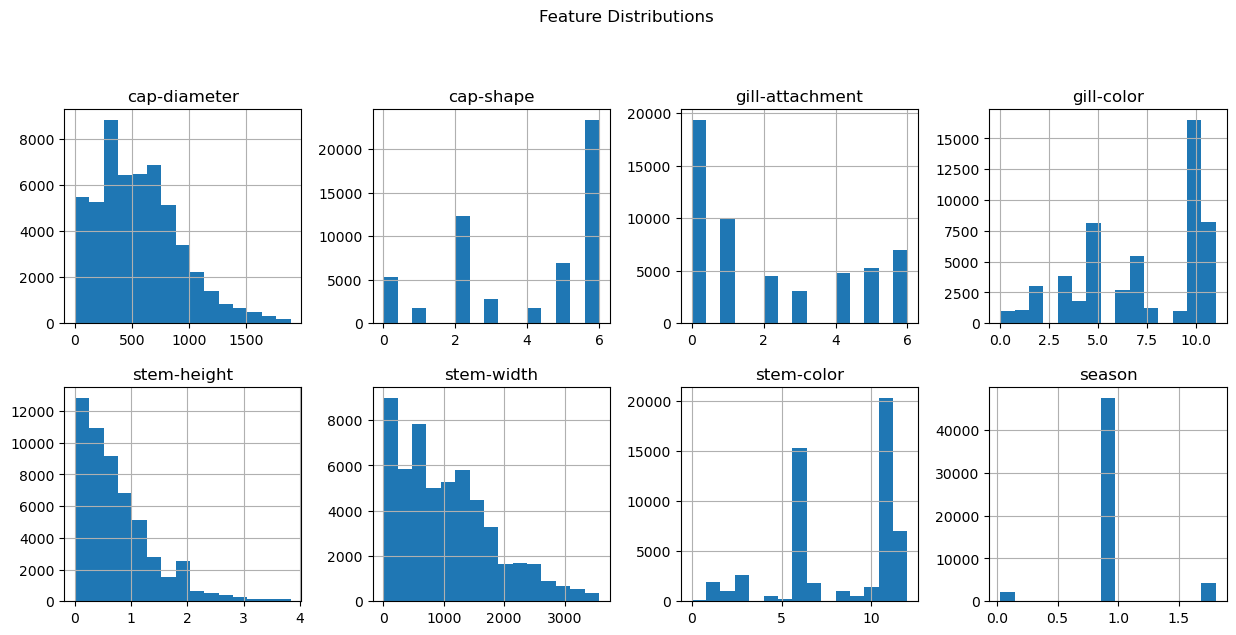

In [15]:
X.hist(bins=15, figsize=(15, 10), layout=(3, 4))
plt.suptitle("Feature Distributions")
plt.show()

In [16]:
# Checking for Data Imbalance
positive_op, negative_op = y.value_counts()
total_samples = y.count()

print("------ Label Imbalance Check ------")
print(f'Number of positive outcomes: {positive_op}, Percentage of positive outcomes: {(positive_op/total_samples)*100:.2f}')
print(f'Number of negative outcomes: {negative_op}, Percentage of negative outcomes: {(negative_op/total_samples)*100:.2f}') 

------ Label Imbalance Check ------
Number of positive outcomes: 29675, Percentage of positive outcomes: 54.92
Number of negative outcomes: 24360, Percentage of negative outcomes: 45.08


In [17]:
majority = df[df['class'] == 0]
minority = df[df['class'] == 1]
minority_upsampled  = resample(minority, replace=True, n_samples=len(majority), random_state=42)
df_balanced = pd.concat([majority, minority_upsampled])

X = df_balanced.drop(columns=['class'])
y = df_balanced['class']

In [18]:
# Feature Selection
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

In [19]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [20]:
X_reshaped = np.expand_dims(X_scaled, axis=1)

In [21]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [22]:
results_rf, results_nb, results_lstm = [], [], []

def calculate_metrics(tp, fp, fn, tn):
    TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
    TNR = tn / (tn + fp) if (tn + fp) > 0 else 0
    FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
    FNR = fn / (fn + tp) if (fn + tp) > 0 else 0

    Precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    Recall = TPR
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0
    Accuracy = (tp + tn) / (tp + tn + fp + fn)
    Error_rate = 1 - Accuracy

    BACC = (TPR + TNR) / 2
    TSS = TPR - FNR
    HSS = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0

    BS = ((fp + fn) / (tp + tn + fp + fn)) ** 2

    return {
        "TPR": TPR, "TNR": TNR, "FPR": FPR, "FNR": FNR,
        "Recall": Recall, "Precision": Precision, "F1": F1,
        "Accuracy": Accuracy, "Error_rate": Error_rate, "BACC": BACC,
        "TSS": TSS, "HSS": HSS, "BS": BS
    }
    

In [23]:
for train_index, test_index in kf.split(X_scaled, y):
    # Get initial train-test split
    X_train_full, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

    # Further split training data into 60% train and 40% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.4, random_state=42, stratify=y_train_full)
    X_train_lstm, X_val_lstm = np.expand_dims(X_train, axis=1), np.expand_dims(X_val, axis=1)

    # Random Forest with enhanced regularization
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_split=15, min_samples_leaf=7, random_state=42, verbose=1)
    rf_model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred_val_rf = rf_model.predict(X_val)
    tp_val_rf, fp_val_rf, fn_val_rf, tn_val_rf = confusion_matrix(y_val, y_pred_val_rf).ravel()
    print("Random Forest Validation Metrics:", calculate_metrics(tp_val_rf, fp_val_rf, fn_val_rf, tn_val_rf))

    # Evaluate on test set
    y_pred_rf = rf_model.predict(X_test)
    tp_rf, fp_rf, fn_rf, tn_rf = confusion_matrix(y_test, y_pred_rf).ravel()
    results_rf.append(calculate_metrics(tp_rf, fp_rf, fn_rf, tn_rf))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.8099074903014025, 'TNR': 0.9161212768799252, 'FPR': 0.0838787231200748, 'FNR': 0.19009250969859742, 'Recall': 0.8099074903014025, 'Precision': 0.9283922462941847, 'F1': 0.8651118312702545, 'Accuracy': 0.8552451539338655, 'Error_rate': 0.14475484606613453, 'BACC': 0.8630143835906638, 'TSS': 0.619814980602805, 'HSS': 0.7104903078677309, 'BS': 0.020953965459630314}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.8010234205864987, 'TNR': 0.9146110056925996, 'FPR': 0.08538899430740038, 'FNR': 0.19897657941350128, 'Recall': 0.8010234205864987, 'Precision': 0.928164196123147, 'F1': 0.8599197126558208, 'Accuracy': 0.8488027366020524, 'Error_rate': 0.1511972633979476, 'BACC': 0.8578172131395492, 'TSS': 0.6020468411729973, 'HSS': 0.6976054732041049, 'BS': 0.022860612459028335}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.807860696517413, 'TNR': 0.9130841121495327, 'FPR': 0.08691588785046729, 'FNR': 0.19213930348258706, 'Recall': 0.807860696517413, 'Precision': 0.925769669327252, 'F1': 0.8628055260361318, 'Accuracy': 0.852793614595211, 'Error_rate': 0.14720638540478903, 'BACC': 0.8604724043334728, 'TSS': 0.615721393034826, 'HSS': 0.7055872291904219, 'BS': 0.021669719903943292}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Random Forest Validation Metrics: {'TPR': 0.8151310563939634, 'TNR': 0.9250133904659882, 'FPR': 0.07498660953401179, 'FNR': 0.18486894360603653, 'Recall': 0.8151310563939634, 'Precision': 0.936145952109464, 'F1': 0.8714573824434774, 'Accuracy': 0.8619156214367161, 'Error_rate': 0.13808437856328393, 'BACC': 0.8700722234299758, 'TSS': 0.6302621127879269, 'HSS': 0.7238312428734321, 'BS': 0.019067295603208304}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.8065026188358534, 'TNR': 0.917935588195661, 'FPR': 0.08206441180433904, 'FNR': 0.19349738116414666, 'Recall': 0.8065026188358534, 'Precision': 0.9305587229190422, 'F1': 0.8641007994070622, 'Accuracy': 0.853648802736602, 'Error_rate': 0.14635119726339796, 'BACC': 0.8622191035157571, 'TSS': 0.6130052376717068, 'HSS': 0.7072976054732041, 'BS': 0.021418672940430022}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.807845084409136, 'TNR': 0.9149933065595717, 'FPR': 0.08500669344042838, 'FNR': 0.19215491559086395, 'Recall': 0.807845084409136, 'Precision': 0.927594070695553, 'F1': 0.8635881104033971, 'Accuracy': 0.8534777651083238, 'Error_rate': 0.14652223489167615, 'BACC': 0.8614191954843539, 'TSS': 0.6156901688182721, 'HSS': 0.7069555302166477, 'BS': 0.021468765317651527}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.8132854578096947, 'TNR': 0.9180196965664094, 'FPR': 0.08198030343359063, 'FNR': 0.1867145421903052, 'Recall': 0.8132854578096947, 'Precision': 0.9297605473204105, 'F1': 0.8676314109384974, 'Accuracy': 0.8581527936145952, 'Error_rate': 0.14184720638540482, 'BACC': 0.8656525771880521, 'TSS': 0.6265709156193895, 'HSS': 0.7163055872291905, 'BS': 0.020120629959343623}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.8017555971989349, 'TNR': 0.9133900824212944, 'FPR': 0.08660991757870558, 'FNR': 0.1982444028010652, 'Recall': 0.8017555971989349, 'Precision': 0.9269099201824401, 'F1': 0.8598022105875509, 'Accuracy': 0.8488597491448119, 'Error_rate': 0.15114025085518812, 'BACC': 0.8575728398101146, 'TSS': 0.6035111943978697, 'HSS': 0.6977194982896238, 'BS': 0.0228433754285692}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Validation Metrics: {'TPR': 0.8085762610685504, 'TNR': 0.9141407397516357, 'FPR': 0.08585926024836427, 'FNR': 0.1914237389314496, 'Recall': 0.8085762610685504, 'Precision': 0.9266818700114025, 'F1': 0.8636097975665479, 'Accuracy': 0.853648802736602, 'Error_rate': 0.14635119726339796, 'BACC': 0.861358500410093, 'TSS': 0.6171525221371008, 'HSS': 0.7072976054732041, 'BS': 0.021418672940430022}
Random Forest Validation Metrics: {'TPR': 0.8110977564102564, 'TNR': 0.911064055055585, 'FPR': 0.08893594494441504, 'FNR': 0.18890224358974358, 'Recall': 0.8110977564102564, 'Precision': 0.9233751425313569, 'F1': 0.863602431481284, 'Accuracy': 0.8541619156214367, 'Error_rate': 0.14583808437856327, 'BACC': 0.8610809057329207, 'TSS': 0.6221955128205128, 'HSS': 0.7083238312428735, 'BS': 0.02126874685520894}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [24]:
for train_index, test_index in kf.split(X_scaled, y):
    # Split data into train and test for the current fold
    X_train_full, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

    # Further split training data into 60% train and 40% validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.4, random_state=None, stratify=y_train_full
    )

    # Naive Bayes Model
    nb_model = GaussianNB(var_smoothing=1e-8)
    nb_model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred_val_nb = nb_model.predict(X_val)
    #y_prob_val_nb = nb_model.predict_proba(X_val)[:, 1]  # For probabilistic metrics
    tp_val_nb, fp_val_nb, fn_val_nb, tn_val_nb = confusion_matrix(y_val, y_pred_val_nb).ravel()
    print("Naive Bayes Validation Metrics:", calculate_metrics(tp_val_nb, fp_val_nb, fn_val_nb, tn_val_nb))

    # Evaluate on test set
    y_pred_test_nb = nb_model.predict(X_test)
    #y_prob_test_nb = nb_model.predict_proba(X_test)[:, 1]
    tp_val_nb, fp_val_nb, fn_val_nb, tn_val_nb = confusion_matrix(y_val, y_pred_val_nb).ravel()
    results_nb.append(calculate_metrics(tp_val_nb, fp_val_nb, fn_val_nb, tn_val_nb))
    #print("Naive Bayes Validation Metrics:", )

Naive Bayes Validation Metrics: {'TPR': 0.634942431604521, 'TNR': 0.6582435278087452, 'FPR': 0.3417564721912548, 'FNR': 0.36505756839547904, 'Recall': 0.634942431604521, 'Precision': 0.6854047890535918, 'F1': 0.6592092997751824, 'Accuracy': 0.6456670467502851, 'Error_rate': 0.3543329532497149, 'BACC': 0.6465929797066331, 'TSS': 0.269884863209042, 'HSS': 0.2913340935005701, 'BS': 0.12555184175866466}
Naive Bayes Validation Metrics: {'TPR': 0.6328726658930267, 'TNR': 0.6562461233097631, 'FPR': 0.34375387669023694, 'FNR': 0.3671273341069733, 'Recall': 0.6328726658930267, 'Precision': 0.684036488027366, 'F1': 0.6574606827771385, 'Accuracy': 0.6436145952109464, 'Error_rate': 0.35638540478905356, 'BACC': 0.6445593946013949, 'TSS': 0.2657453317860534, 'HSS': 0.2872291904218928, 'BS': 0.1270105567466576}
Naive Bayes Validation Metrics: {'TPR': 0.635800491295525, 'TNR': 0.6554971260853614, 'FPR': 0.34450287391463863, 'FNR': 0.36419950870447504, 'Recall': 0.635800491295525, 'Precision': 0.678791

In [25]:
for train_index, test_index in kf.split(X_scaled, y):
    X_train_full, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

    # Further split training data into 60% train and 40% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.4, random_state=42, stratify=y_train_full)
    X_train_lstm, X_val_lstm = np.expand_dims(X_train, axis=1), np.expand_dims(X_val, axis=1)

    
    # LSTM with early stopping and enhanced regularization
    lstm_model = Sequential()
    lstm_model.add(LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu', kernel_regularizer='l2'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

    # Evaluate on test set
    y_pred_lstm = (lstm_model.predict(np.expand_dims(X_test, axis=1)) > 0.5).astype("int32")
    tp_lstm, fp_lstm, fn_lstm, tn_lstm = confusion_matrix(y_test, y_pred_lstm).ravel()
    results_lstm.append(calculate_metrics(tp_lstm, fp_lstm, fn_lstm, tn_lstm))

Epoch 1/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5982 - loss: 0.7387 - val_accuracy: 0.6441 - val_loss: 0.6756
Epoch 2/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6408 - loss: 0.6734 - val_accuracy: 0.6413 - val_loss: 0.6682
Epoch 3/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6327 - loss: 0.6693 - val_accuracy: 0.6471 - val_loss: 0.6654
Epoch 4/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6400 - loss: 0.6649 - val_accuracy: 0.6445 - val_loss: 0.6634
Epoch 5/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6368 - loss: 0.6636 - val_accuracy: 0.6435 - val_loss: 0.6618
Epoch 6/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6320 - loss: 0.6631 - val_accuracy: 0.6437 - val_loss: 0.6607
Epoch 7/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6387 - loss: 0.6612 - val_accuracy: 0.6453 - val_loss: 0.6596
Epoch 8/15
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6333 - loss: 0.6628 - val_accuracy: 0

In [26]:
metrics_rf_df = pd.DataFrame(results_rf)
metrics_nb_df = pd.DataFrame(results_nb)
metrics_lstm_df = pd.DataFrame(results_lstm)

In [27]:
# Compute Average Metrics
average_rf = metrics_rf_df.mean()
average_nb = metrics_nb_df.mean()
average_lstm = metrics_lstm_df.mean()

In [28]:
# Display Results
print("Random Forest Results (Per Fold):\n", metrics_rf_df)
print("Random Forest Average Metrics:\n", average_rf)

print("Naive Bayes Results (Per Fold):\n", metrics_nb_df)
print("Naive Bayes Average Metrics:\n", average_nb)

print("LSTM Results (Per Fold):\n", metrics_lstm_df)
print("LSTM Average Metrics:\n", average_lstm)

Random Forest Results (Per Fold):
         TPR       TNR       FPR       FNR    Recall  Precision        F1  \
0  0.814478  0.907207  0.092793  0.185522  0.814478   0.919130  0.863645   
1  0.806762  0.918041  0.081959  0.193238  0.806762   0.930624  0.864278   
2  0.813108  0.915036  0.084964  0.186892  0.813108   0.926929  0.866296   
3  0.805288  0.912205  0.087795  0.194712  0.805288   0.925287  0.861127   
4  0.804263  0.916383  0.083617  0.195737  0.804263   0.929392  0.862312   
5  0.814245  0.922522  0.077478  0.185755  0.814245   0.933908  0.869981   
6  0.804105  0.903103  0.096897  0.195895  0.804105   0.916667  0.856704   
7  0.799504  0.912640  0.087360  0.200496  0.799504   0.926519  0.858338   
8  0.813419  0.918945  0.081055  0.186581  0.813419   0.930624  0.868083   
9  0.802557  0.914397  0.085603  0.197443  0.802557   0.927750  0.860625   

   Accuracy  Error_rate      BACC       TSS       HSS        BS  
0  0.854885    0.145115  0.860842  0.628956  0.709770  0.02105

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


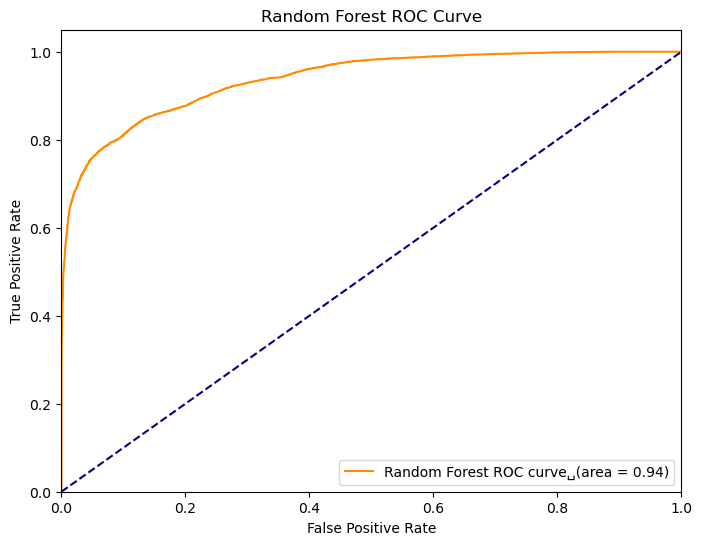

In [29]:
# Obtain predicted probabilities
y_score_rf = rf_model.predict_proba(X_scaled)[:, 1]
# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(y, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color="darkorange", label="Random Forest ROC curve␣(area = {:.2f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

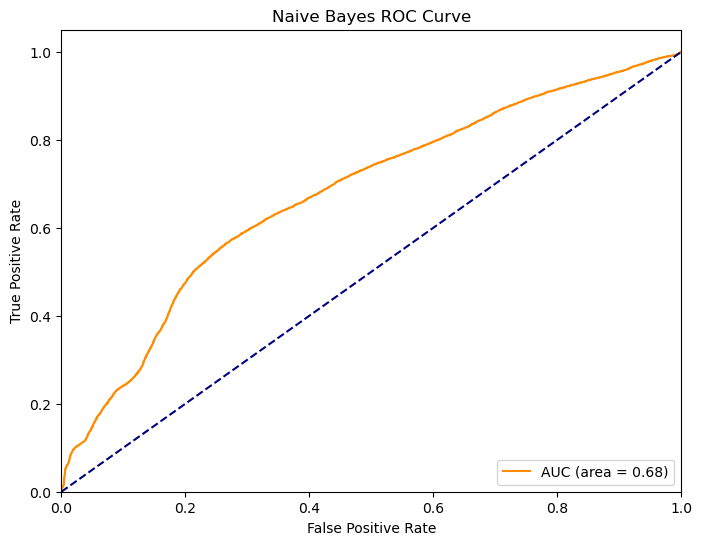

In [30]:
# Obtain predicted probabilities
y_score_nb = nb_model.predict_proba(X_scaled)[:, 1]
# Compute ROC curve and ROC area
fpr_nb, tpr_nb, _ = roc_curve(y, y_score_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot SVM ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_nb))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC Curve")
plt.legend(loc="lower right")
plt.show()

1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


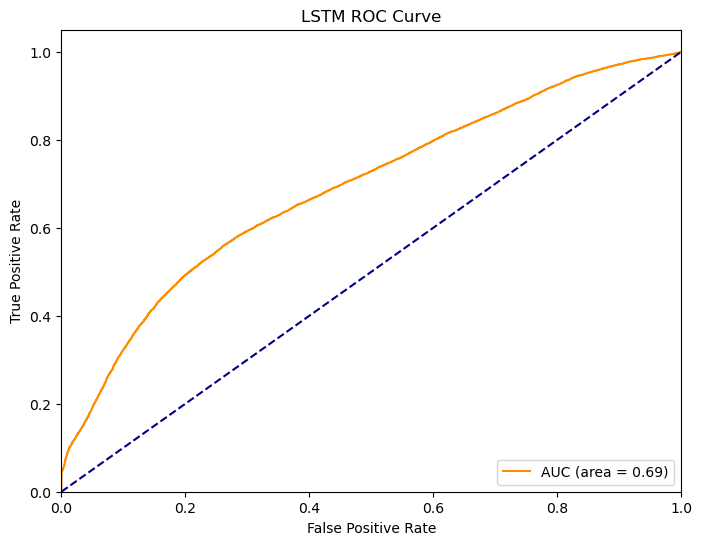

In [31]:
# Predict probabilities for the test set
predict_lstm = lstm_model.predict(X_reshaped)
# Compute ROC curve and ROC area
fpr_lstm, tpr_lstm, _ = roc_curve(y, predict_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
# Plot LSTM ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()
